In [ ]:
import preprocess
import utils

#preprocess.audio_process(td = 'F:\\github\\HP6_collab\\audio\\raw\\hp\\', sf=4000)
#utils.move_to_folder(source='F:\\github\\HP6_collab\\audio\\raw\\hp\\filtered\\', target='F:\\github\\HP6_collab\\audio\\filtered\\')

#preprocess.few_second_clips(td= 'F:\\github\\HP6_collab\\audio\\raw\\hp\\filtered\\', clip = 30)
#preprocess.few_second_clips(td= 'F:\\github\\HP6_collab\\audio\\raw\\noaa\\', clip = 30)
#utils.filename_to_csv(td= 'F:\\github\\HP6_collab\\audio\\filtered\\30s_clip\\')


In [ ]:
import preprocess
import utils

preprocess.audio_process(td='F:\\github\\HP6_collab\\audio\\explanation\\', sf=4000)
preprocess.spec_process(td='F:\\github\\HP6_collab\\audio\\explanation\\filtered\\', mid=70)


In [26]:
import pandas as pd
import librosa
import pandas as pd
import numpy as np
import os
import soundfile as sf
from pydub import AudioSegment
from scipy.signal import butter, lfilter, freqz

td= 'F:\\github\\HP6_collab\\audio\\explanation\\'
#name ='240514_0093_600'
name = 'humpbackwhale_MB02_03_0'

# Load audio file
aud, sr = librosa.load(f'{td}{name}.wav')

# big pre-process function
order=5
cutoff=[50,1500]
sr2=cutoff[1]*2+1000

# read file with sr=4000hz and mono
aud2, sr2 = librosa.load(f'{td}{name}.wav', sr= sr2, mono=True)

print(f'Sampling rate of original audio is {sr/1000}kHz')
print(f'Duration is {int(len(aud)/sr)}s')
print(f'New sampling rate is {sr2/1000}kHz')
print(f'Duration is {int(len(aud2)/sr2)}s')

Sampling rate of original audio is 22.05kHz
Duration is 10s
New sampling rate is 4.0kHz
Duration is 10s


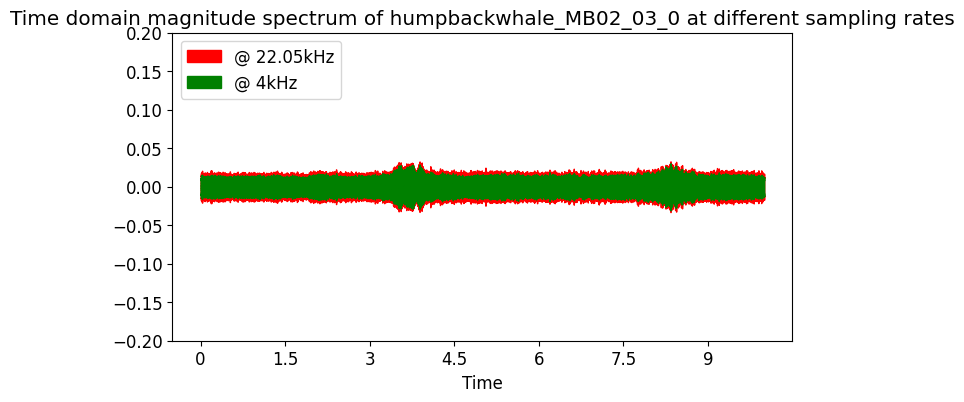

In [27]:
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(8,4))
librosa.display.waveshow(aud, sr=sr, color = 'red', label = '@ 22.05kHz')
#plotting the sampled signal
librosa.display.waveshow(aud2, sr=sr2, color = 'green', label = '@ 4kHz')
plt.legend(loc='upper left')
plt.title(f'Time domain magnitude spectrum of {name} at different sampling rates')
plt.ylim(-0.2, 0.2)
plt.savefig(f'{td}timedomain1_{name}.png')
plt.show()
plt.clf()
plt.close()

In [28]:
#import IPython.display as ipd
#ipd.Audio(aud, rate=sr)

#import soundfile as sf
#sf.write(f'F:\\aud.wav', aud, sr)
#sf.write(f'F:\\aud2.wav', aud2, sr2)

In [29]:
# add band pass filter 50 - 1500hz order=5
## Generate butterworth coefficients a,b
a,b = butter(N= order, Wn = cutoff, fs=sr2, btype='band', analog=False)
## Apply filter that returns filtered audio y
y = lfilter(a,b, aud2)


In [30]:
plt.figure(figsize=(8,5))

librosa.display.waveshow(aud, sr=sr, alpha =1, color = 'red', label='original audio')
librosa.display.waveshow(aud2, sr=sr2, alpha =1, color = 'green', label='@ 4kHz unfiltered')
librosa.display.waveshow(y, sr=sr2, alpha =1, color='blue',label=f'bandpass filter {cutoff}')
plt.legend(loc='upper left')
plt.title(f'Time domain magnitude spectrum of {name}')
plt.ylim((-0.2,0.2))
#plt.show()
plt.savefig(f'{td}timedomain2_{name}.png')
plt.clf()
plt.close()

In [31]:
aud_ft = np.fft.fft(aud)
aud_magnitude_spectrum = np.abs(aud_ft)
freq_aud = np.linspace(0,sr, len(aud_magnitude_spectrum))
nf_splice_aud = int(len(freq_aud)/2)

aud2_ft = np.fft.fft(aud2)
aud2_magnitude_spectrum = np.abs(aud2_ft)
freq_aud2 = np.linspace(0,sr2, len(aud2_magnitude_spectrum))
nf_splice_aud2 = int(len(freq_aud2)/2)

y_ft = np.fft.fft(y)
y_magnitude_spectrum = np.abs(y_ft)
freq_y = np.linspace(0,sr2, len(y_magnitude_spectrum))
nf_splice_y = int(len(freq_y)/2)

plt.figure(figsize=(8,5))

plt.plot(freq_aud[:nf_splice_aud], aud_magnitude_spectrum[:nf_splice_aud] , color = 'red', label = 'original audio')
plt.plot(freq_aud2[:nf_splice_aud2], aud2_magnitude_spectrum[:nf_splice_aud2] , color = 'green', label = '@ 4kHz unfiltered')
plt.plot(freq_y[:nf_splice_y], y_magnitude_spectrum[:nf_splice_y], color = 'blue', label ='bandpass filter {cutoff}')
plt.legend(loc = 'upper left')
#plt.ylim((0,50))
#plt.xlim(0,500)
plt.xlabel('Freq(Hz)')
plt.ylabel('Magnitude')
plt.title(f'Freq domain magnitude spectrum of {name}')
plt.savefig(f'{td}freqdomain_{name}.png')
#plt.show()
plt.clf()
plt.close()

spectrogram

In [32]:
import imageio.v3 as iio
import matplotlib.colors as colors

In [33]:
def spec(aud, tag, fft_n = 1024, hop_size = 512, sr=sr,
         min_dB = 0, max_dB = 100,
         cmap_name = 'viridis', mid=50,):
    ## calculate short time FT
    aud_sfft = librosa.stft(aud, n_fft=fft_n, hop_length=hop_size)

    ## Converts stft output of complex numbers into abs no for better visualization
    aud_y = np.abs(aud_sfft)**2 

    ## convert from power to dB 
    aud_y_log = librosa.power_to_db(aud_y)

    ## Normalize the spectrogram to the range min and max dB

    ### Get the min and max of the original dB spectrogram
    aud_y_log_min = np.min(aud_y_log)
    aud_y_log_max = np.max(aud_y_log)

    ### Rescale the dB spectrogram to the desired range
    aud_y_log_norm = min_dB + ((aud_y_log - aud_y_log_min) / (aud_y_log_max - aud_y_log_min)) * (max_dB - min_dB)
    
    plt.figure(figsize=(40,15))  # 3.11, 3.11 creates a plot that will result in a 224x224 resolution (224 px / 72 DPI = ~3.11 inches)
    
    if (mid==50): # if no value specified, make default spectrogram
          librosa.display.specshow(aud_y_log_norm, sr=sr,hop_length=hop_size, y_axis='log', cmap=cmap_name)
    else: # if value specified, then use
          ## Define the normalization mid point for cmap
          diversity_norm = colors.TwoSlopeNorm(vcenter=mid)
          librosa.display.specshow(aud_y_log_norm, sr=sr,hop_length=hop_size, y_axis='log', cmap=cmap_name,norm = diversity_norm)
    
    #plt.colorbar(format='%+2.f')
    plt.ylim((0,2500))
    ## Plot 
    plt.rcParams.update({'font.size': 12})
    plt.title(f'Spectrogram of {name}')
    #plt.yticks([]) # Remove y ticks
    #plt.xticks([]) # Remove x ticks  
    #plt.show()
    plt.savefig(f'{td}spec{tag}_{name}.png')
    plt.clf()
    plt.close()

In [34]:
spec(aud=aud, sr=sr, fft_n = 1024, hop_size=512, mid=70, tag='og')

In [35]:
spec(aud=y, sr=sr2,fft_n = 256, hop_size=128, mid=70, tag='process')